<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>Cuts Optimization using Extra Gradient Boosting
<br></p><br>

Over the last years, **Machine Learning** tools have been successfully applied to problems in high-energy physics. For example, for the classification of physics objects. Supervised machine learning algorithms allow for significant improvements in classification problems by taking into account observable correlations and by learning the optimal selection from examples, e.g. from Monte Carlo simulations.


# Importing the Libraries

**Numpy** is a powerful library that makes working with python more efficient, so we will import it and use it as np in the code. **Pandas** is another useful library that is built on numpy and has two great objects *series* and *dataframework*. Pandas works great for *data ingestion* and also has *data visualization* features. From **Hipe4ml** we import **TreeHandler** and with the help of this function we will import our *Analysis Tree* to our notebook.

**Matplotlib** comes handy in plotting data while the machine learning is performed by **XGBOOST**. We will import data splitter from **Scikit-learn** as *train_test_split*. **Evaluation metrics** such as *confusion matrix*, *Receiver operating characteristic (ROC)*, and *Area Under the Receiver Operating Characteristic Curve (ROC AUC)*  will be used to asses our models.

A **Confusion Matrix** $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true positives is $C_{00}$, false negatives $C_{01}$,false positives is $C_{10}$, and true neagtives is $C_{11}$.

If $ y^{'}_{i} $ is the predicted value of the $ i$-th sample and $y_{i}$ is the corresponding true value, then the fraction of correct predictions over $ n_{samples}$ is defined as 
$$
True \: positives (y,y^{'}) =  \sum_{i=1}^{n_{samples} } 1 (y^{'}_{i} = y_{i}=1)
$$ 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform

from numpy import sqrt, log
from numpy import argmax
import weakref 

from bayes_opt import BayesianOptimization

import uproot
from root_pandas import read_root


from data_cleaning import clean_df
from KFPF_lambda_cuts import KFPF_lambda_cuts

Welcome to JupyROOT 6.22/07


In [2]:
#To save some memory we will delete unused variables
class TestClass(object): 
    def check(self): 
        print ("object is alive!") 
    def __del__(self): 
        print ("object deleted") 

In [3]:
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(8)

# Importing the data
CBM has a modified version of the cern's root software and it contains the simulated setup of CBM. Normally, a model generated input file, for example a URQMD 12 AGeV, is passed through different macros. These macros represent the CBM setup and it is like taking particles and passing them through a detector. These particles are registered as hits in the setup. Then particles' tracks are reconstructed from these hits using cellular automaton and Kalman Filter mathematics.


CBM uses the **tree** format of cern root to store information. To reduce the size of these root files a modified tree file was created by the name of Analysis tree. This Analysis tree file contains most of the information that we need for physics analysis. 

In this example, we download three Analysis Trees. The first one contains mostly background candidates for lambda i.e. protons and pions which do not come from a lambda. The second file contains mostly signal candidates of lamba i.e. it contains protons and pions which come from a lambda decay. The third one contains 10k events generated using URQMD generator with 12 AGeV energy.

In [4]:
# We import three root files into our jupyter notebook
signal = read_root('/home/shahid/cbmsoft/Data/PFSimplePlainTreeSignal.root','PlainTree')
# We only select lambda candidates
sgnal = signal[(signal['LambdaCandidates_is_signal']==1) & (signal['LambdaCandidates_mass']>1.108)
               & (signal['LambdaCandidates_mass']<1.1227)]

# Similarly for the background
background = read_root('/home/shahid/cbmsoft/Data/PFSimplePlainTreeBackground.root','PlainTree')
bg = background[(background['LambdaCandidates_is_signal'] == 0)
                & ((background['LambdaCandidates_mass'] > 1.07)
                & (background['LambdaCandidates_mass'] < 1.108) | (background['LambdaCandidates_mass']>1.1227) 
                   & (background['LambdaCandidates_mass'] < 2.00))]


del signal
del background

In [5]:
# The 10k events data set
df_original = read_root('/home/shahid/cbmsoft/Data/10k_events_PFSimplePlainTree.root','PlainTree')

In [6]:
#The labels of the columns in the df data frame are having the prefix LambdaCandidates_ so we rename them
new_labels= ['chi2geo', 'chi2primneg', 'chi2primpos', 'chi2topo', 'cosineneg',
       'cosinepos', 'cosinetopo', 'distance', 'eta', 'l', 'ldl',
       'mass', 'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity',
             'x', 'y', 'z', 'daughter1id', 'daughter2id', 'isfrompv', 'pid', 'issignal']

df_original.columns=new_labels
sgnal.columns = new_labels
bg.columns = new_labels

#Let's see how the dataframe object df looks like
#df_original

The above data frame object has some columns/features and for them at the very last column the true Monte Carlos information is available. This MC information tells us whether this reconstructed particle was originally produced as a decaying particle or not. So a value of 1 means that it is a true candidate and 0 means that it is not.

# Data Cleaning
Sometimes a data set contains entries which do not make sense. For example, infinite values or NaN entries. We clean the data by removing these entries. Ofcourse, we lose some data points but these outliers sometimes cause problems when we perform analysis. 

Since our experiment is a fixed target experiment so there are certain constraints which have to be applied on the data as well.

In [7]:
#Creating a new data frame and saving the results in it after cleaning of the original dfs
#Also keeping the original one
bcknd = clean_df(bg)
signal = clean_df(sgnal)
df_clean = clean_df(df_original)

del bg
del sgnal

In [8]:
del df_original

# Selecting Background and Signal
Our sample contains a lot of background (2178718) and somewhat signal candidates (36203). For analysis we will use a signal set of 4000 candidates and a background set of 12000 candidates. The background and signal candidates will be selected by using MC information.

In [9]:
# We randomly choose our signal set of 4000 candidates
signal_selected= signal.sample(n=90000)

#background = 3 times the signal is also done randomly
background_selected = bcknd

del signal
del bcknd

In [10]:
#Let's combine signal and background
dfs = [signal_selected, background_selected]
df_scaled = pd.concat(dfs)

In [11]:
# Let's shuffle the rows randomly
df_scaled = df_scaled.sample(frac=1)
del dfs
# Let's take a look at the top 10 entries of the df
df_scaled.iloc[0:10,:]

,chi2geo,chi2primneg,chi2primpos,chi2topo,cosineneg,cosinepos,cosinetopo,distance,eta,l,...,pz,rapidity,x,y,z,daughter1id,daughter2id,isfrompv,pid,issignal
125456,1.264959,3603.395508,2978.606445,1.204196,0.940794,0.998405,0.999971,0.181247,2.420511,8.167913,...,1.984055,1.298298,1.546101,-0.058854,8.027164,471.0,252.0,0.0,3122.0,1.0
189803,1.547112,15.087948,0.095412,2.714692,0.999656,0.999940,0.999941,0.230369,3.480420,4.222751,...,4.591040,2.068335,0.048561,-0.333145,4.222316,240.0,162.0,0.0,3122.0,0.0
477015,6.923366,8.003510,6.882685,5.426916,0.990920,0.992231,0.983067,0.124541,2.454316,0.100614,...,2.329260,1.291904,0.192930,-0.141938,0.086587,127.0,109.0,0.0,3122.0,0.0
57654,5.728300,2.833282,3.312725,2.047969,0.997508,0.997320,0.646019,0.005759,2.224169,0.000694,...,5.049699,1.766251,-0.015536,0.018110,0.006361,126.0,171.0,0.0,3122.0,0.0
330663,0.868387,543231.812500,35190.375000,0.470812,0.944284,0.998617,1.000000,0.004988,2.901293,5.722093,...,2.141836,1.387511,-0.105896,0.871515,5.693000,93.0,77.0,0.0,3122.0,1.0
556000,5.717398,10.896736,1.593740,3.830730,0.957055,0.994079,0.990417,0.053834,2.623692,0.096179,...,2.606829,1.458732,0.021958,-0.093280,0.093925,67.0,62.0,0.0,3122.0,0.0
87070,1.602541,2706.367188,77.682251,0.908254,0.996489,0.999876,0.999996,0.150611,2.805558,9.678487,...,7.685510,2.366184,1.145822,0.166275,9.612197,208.0,175.0,0.0,3122.0,1.0
328496,0.584094,9.402885,0.518631,2.899597,0.876312,0.999768,0.999769,0.180235,2.796551,1.617604,...,6.828983,2.153287,0.083520,-0.081467,1.605318,105.0,71.0,0.0,3122.0,0.0
228027,3.592514,8.207214,1.979630,2.162431,0.913905,0.992617,0.993367,0.155657,3.498562,0.295184,...,3.857150,1.713483,-0.000852,0.188907,0.284930,321.0,54.0,0.0,3122.0,0.0
529249,19.583164,6.007696,340288.937500,4457.123047,0.960249,0.990474,0.957127,0.501260,3.361045,16.679560,...,2.098746,1.301835,1.276144,3.741682,16.985256,106.0,416.0,0.0,3122.0,0.0


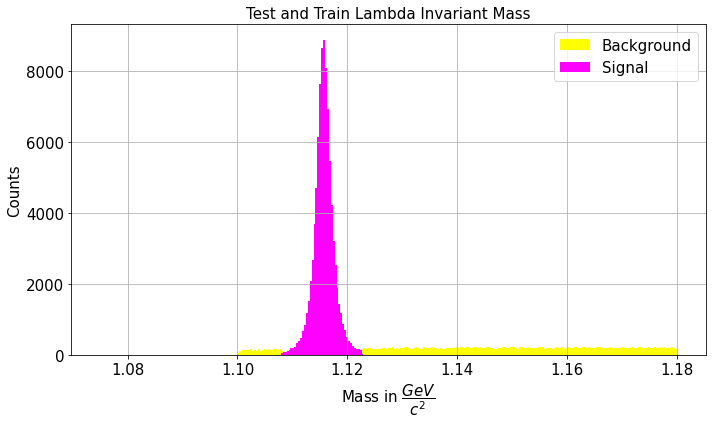

In [12]:
range1 = (1.075, 1.18)
fig, axs = plt.subplots(figsize=(10, 6))
#df_scaled['mass'].plot.hist(bins = 300, range=range1,grid=True,sharey=True)
df_scaled['mass'].plot.hist(bins = 300, facecolor='yellow',grid=True,range=range1)
signal_selected['mass'].plot.hist(bins = 300, facecolor='magenta',grid=True, range=range1)
plt.ylabel("Counts", fontsize=15)
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Test and Train Lambda Invariant Mass', fontsize = 15)
plt.legend(('Background', 'Signal'), fontsize = 15)
fig.tight_layout()
fig.savefig("signal_bac_invmass_MC.png")

# Creating Train and Test sets
To make machine learning algorithms more efficient on unseen data we divide our data into two sets. One set is for training the algorithm and the other is for testing the algorithm. If we don't do this then the algorithm can overfit and we will not capture the general trends in the data. 

In [ ]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
cuts = [ 'chi2primneg', 'chi2primpos', 'ldl', 'distance', 'chi2geo','cosinepos']


x = df_scaled[cuts].copy()

In [ ]:
# The MC information is saved in this y variable
y =pd.DataFrame(df_scaled['issignal'], dtype='int')
type(y)

## Whole set

In [ ]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
x_whole = df_clean[cuts].copy()
# The MC information is saved in this y variable
y_whole = pd.DataFrame(df_clean['issignal'], dtype='int')

# KFPF

In [13]:
#returns a new df 
new_check_set=KFPF_lambda_cuts(df_clean)

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>XGB Boost 
<br></p><br>

## Bayesian
In order to find the best parameters of XGB for our data we use Bayesian optimization. Grid search and and random search could also do the same job but bayesian is more time efficient.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=324)

In [ ]:
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_whole, label = y_whole)
dtest1=xgb.DMatrix(x_test, label = y_test)

### Hyper parameters

*subsample* [default=1]
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
range: (0,1]

*eta* [default=0.3, alias: learning_rate]
Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
range: [0,1]


*gamma* [default=0, alias: min_split_loss]
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
range: [0,∞]


*alpha* [default=0, alias: reg_alpha]
L1 regularization term on weights. Increasing this value will make model more conservative.

*Lasso Regression* (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [ ]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, alpha, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'auc', 'nthread' : 7}
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    return  cv_result['test-auc-mean'].iloc[-1]



In [ ]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'gamma': (0, 1),
                                            'alpha': (2,20),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,500)
                                            })

In [ ]:
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=15, init_points=8, acq='ei')
#0.9952

In [ ]:
# best target so far 0.994872
print(xgb_bo.max)

# XGB models

## New models for treelite

In [ ]:
max_param = xgb_bo.max['params']
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'], 'max_depth': int(round(max_param['max_depth'],0)), 'n_estimators': int(round(max_param['n_estimators'],0)), 'objective': 'binary:logistic'}

In [ ]:
bst = xgb.train(param, dtrain)

In [ ]:
bst1= bst.predict(dtrain)

In [ ]:
bst_test = bst.predict(dtest1)

In [ ]:
def AMS(y_true, y_predict, y_true1, y_predict1):
    roc_auc=roc_auc_score(y_true, y_predict)
    fpr, tpr, thresholds = roc_curve(y_true, y_predict,drop_intermediate=False ,pos_label=1)
    S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
    S0 = S0[~np.isnan(S0)]
    xi = argmax(S0)
    S0_best_threshold = (thresholds[xi])
    
    roc_auc1=roc_auc_score(y_true1, y_predict1)
    fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_predict1,drop_intermediate=False ,pos_label=1)
    S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))
    S01 = S01[~np.isnan(S01)]
    xi1 = argmax(S01)
    S0_best_threshold1 = (thresholds[xi1])
    
    fig, axs = plt.subplots(figsize=(15, 10), dpi = 100)
    plt.plot(fpr, tpr, linestyle=':',color='darkorange',label='ROC curve train (area = %0.4f)' % roc_auc)
    plt.plot(fpr1, tpr1, color='green',label='ROC curve test (area = %0.4f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.scatter(fpr[xi], tpr[xi], marker='o', color='black', label= 'Best Threshold train set = '+"%.4f" % S0_best_threshold +'\n S0 = '+ "%.2f" % S0[xi])
    plt.scatter(fpr1[xi1], tpr1[xi1], marker='o', color='blue', label= 'Best Threshold test set = '+"%.4f" % S0_best_threshold1 +'\n S0 = '+ "%.2f" % S01[xi1])
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.legend(loc="lower right", fontsize = 15)
    plt.title('Receiver operating characteristic', fontsize = 15)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.02])
    #axs.axis([-0.01, 1, 0.9, 1])
    fig.tight_layout()
    plt.show()

In [ ]:
AMS(y_train, bst1,y_test, bst_test)

In [ ]:
df_clean['xgb_preds'] = bst.predict(dtest)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
df_clean['xgb_preds'].plot.hist(ax=ax, bins=300,facecolor='red',alpha = 0.3, bottom=0.001)
TP = df_clean[(df_clean['issignal']==1)]
TP['xgb_preds'].plot.hist(ax=ax, bins=300,facecolor='blue',alpha = 0.3, bottom=0.001)
ax.set_yscale('log')
plt.legend(('XGB predicted probability distribution','True positives = (MC =1) True lamdas in the distribution'), fontsize = 15, loc='upper right')
plt.title("XGB returned probablility for the 10k events data set", fontsize = 15)
plt.ylabel("Log scale number of counts", fontsize = 15)
plt.xlabel("Probability", fontsize = 15)
fig.tight_layout()
fig.savefig("hists.png")

In [ ]:
roc_auc=roc_auc_score(y_whole, df_clean['xgb_preds'])
fpr, tpr, thresholds = roc_curve(y_whole, df_clean['xgb_preds'],drop_intermediate=False ,pos_label=1)
S0 = sqrt(2 * ((tpr + fpr) * log(1 + tpr/fpr) - tpr))
S0 = S0[~np.isnan(S0)]
xi = argmax(S0)
S0_best_threshold = (thresholds[xi])
print('Best Threshold=%f, S0=%.3f' % (thresholds[xi], S0[xi]))

In [ ]:
labels = dtest.get_label()
print('error=%f' %
      (sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i]) /
       float(len(preds))))

In [ ]:
import treelite
model = treelite.Model.from_xgboost(bst)
toolchain = 'clang'
model.export_lib(toolchain=toolchain, libpath='./mymodel.so',
                 params={'parallel_comp': 8}, verbose=True)

# Operating system of the target machine
platform = 'unix'

# Save the source package as a zip archive named mymodel.zip
# Later, we'll use this package to produce the library mymodel.so.
model.export_srcpkg(platform=platform, toolchain=toolchain,
                    pkgpath='./mymodel.zip', libname='mymodel.so',
                    verbose=True)

In [ ]:
!unzip -l mymodel.zip

In [ ]:
import treelite_runtime     # runtime module
predictor = treelite_runtime.Predictor('./mymodel.so', verbose=True)

In [ ]:
x_whole_nump = pd.DataFrame.to_numpy(x_whole)

In [ ]:
batch = treelite_runtime.Batch.from_npy2d(x_whole_nump)
df_clean['tree_lite'] = predictor.predict(batch)

In [ ]:
plt.hist(out_pred,bins=300, range=(0.5,1) )
plt.show()

## Already working model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
xg_reg = xgb.XGBRegressor(learning_rate = 0.09273,
                max_depth = 9, alpha = 3.085, gamma =0.1481 , n_estimators = 115, nthread=8)

In [ ]:
train_pred = xg_reg.fit(x_train,y_train)

In [ ]:
preds = xg_reg.predict(x_test)

In [ ]:
df_clean['xgb_preds'] =xg_reg.predict(x_whole)

In [ ]:
df_clean['xgb_preds'].describe()

In [ ]:
AUC_score = roc_auc_score(y_train, xg_reg.predict(x_train))
print("AUC: %f" % (AUC_score))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
roc_auc_score(y_test, preds)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_whole, df_clean['xgb_preds']))
print("RMSE: %f" % (rmse))

In [ ]:
roc_auc_score(y_whole, df_clean['xgb_preds'])

In [ ]:
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [8, 4]
plt.show()
ax.figure.tight_layout() 
ax.figure.savefig("hits.png")

In [ ]:
def cut_visualization(cut, range1=(1.09, 1.19), bins1= 300 ):
    mask1 = df_clean['xgb_preds']>cut
    df3=df_clean[mask1]
    
    fig, ax2 = plt.subplots(figsize=(15, 10), dpi = 200)
    color = 'tab:blue'
    ax2.hist(df_clean['mass'],bins = bins1, range=range1, facecolor='blue',alpha = 0.35, label='before selection')
    ax2.set_ylabel('Counts', fontsize = 15, color=color)
    ax2.set_xlabel('Mass in GeV', fontsize = 15)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend( fontsize = 15, loc='upper left')
    
    color = 'tab:red'
    ax1 = ax2.twinx()
    ax1.hist(df3['mass'], bins = bins1, range=range1, facecolor='red',alpha = 0.35, label='Machine learning (XGB)')
    ax1.set_xlabel('Mass in GeV', fontsize = 15)
    ax1.set_ylabel('Counts ', fontsize = 15, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend( fontsize = 15,loc='upper right' )
    
    
    
    plt.title("The sample's Invariant Mass with XGB (with a cut > "+str(cut)+')', fontsize = 15)
    fig.tight_layout()
    #fig.savefig("whole_sample_invmass_with_ML.png")

In [ ]:
cut_visualization(S0_best_threshold)

In [ ]:
mask1 = df_clean['xgb_preds']>0.969618
df3=df_clean[mask1]
df3_clean_signal_mask = df3['issignal']>0
df3_clean_signal = df3[df_clean_signal_mask]
df3_clean_bac_mask = df3['issignal']==0
df3_clean_bac = df3[df_clean_bac_mask]
#vars_to_draw.remove('xgb_preds')



In [ ]:
mask10 = (df_clean['xgb_preds1']==1)&(df_clean['issignal']==1)
df4=df_clean[mask1]

In [ ]:
leg_labels = ['original background', 'background inside XGB predicted signal']
vars_to_draw = list(df3.columns)
ax = plot_utils.plot_distr([df_clean_bac, df3_clean_bac], vars_to_draw, bins=100, labels=leg_labels, log=True, density=True, figsize=(30, 20), alpha=0.3, grid=False)
plt.tight_layout()
plt.savefig("hits.png")

In [ ]:
cut3 = S0_best_threshold
mask1 = df_clean['xgb_preds']>cut3
df3=df_clean[mask1]
fig, axs = plt.subplots(figsize=(15, 10))

range1= (1.09, 1.7)

#xgb

df3_new = df3[df3['issignal']==1]
df3_new1 = df3[df3['issignal']==0]
df3['mass'].plot.hist(bins = 300, range=range1, facecolor='red',alpha = 0.3,grid=True,sharey=True)
#df3_new['mass'].plot.hist(bins = 300, range=range1,facecolor='blue',alpha = 0.3,grid=True,sharey=True)
df3_new1['mass'].plot.hist(bins = 300, range=range1,facecolor='green',alpha = 0.3,grid=True,sharey=True)
plt.legend(('XGB selected lambdas','\n False positives = \n (MC =0)\n background in \n the distribution' ), fontsize = 18, loc='upper right')
#plt.rcParams["legend.loc"] = 'upper right'
plt.title("KFPF variables + cos$\Theta_{between \ \overrightarrow{P_\Lambda} \  & \ \overrightarrow{P_{\Pi^-}}}$ + $P_T$  with a cut of %.4f "%cut3 +"on the XGB probability distribution", fontsize = 18)
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
axs.tick_params(labelsize=18)
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")

## Confusion Matrix

By definition a confusion matrix $C$ is such that $C_{i, j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

Thus in binary classification, the count of true positives is $C_{0,0}$, false positives is $C_{1,0}$, true negatives is $C_{1,1}$ and false negatives is $C_{0,1}$.

The following function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

In [ ]:
cut1 = S0_best_threshold
df_clean['xgb_preds1'] = ((df_clean['xgb_preds']>cut1)*1)
cnf_matrix = confusion_matrix(y_whole, df_clean['xgb_preds1'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=['signal','background'], title='Confusion Matrix for XGB for cut > '+str(cut1))
plt.savefig('confusion_matrix_extreme_gradient_boosting_whole_data.png')

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>Tree visualization
<br></p><br>

In [ ]:
#fig, ax1 = plt.subplots(figsize=(15, 10), dpi = 200)
xgb.plot_tree(xg_reg,num_trees=10)
plt.rcParams['figure.figsize'] = [20, 40]
plt.rcParams['figure.dpi']=200
plt.show()

In [ ]:
xgb.to_graphviz(xg_reg, fmap='', num_trees=0, rankdir=None, yes_color=None, no_color=None, condition_node_params=None, leaf_node_params=None)

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import matplotlib.pyplot as plt

# Define objective function
def f(x):
    return {'loss': x ** 2 - x, 'status': STATUS_OK}

# Run hyperopt optimization
trials = Trials()
result = fmin(
    fn=f,                           # objective function
    space=hp.uniform('x', -1, 1),   # parameter space
    algo=tpe.suggest,               # surrogate algorithm
    max_evals=500,                  # no. of evaluations
    trials=trials                   # trials object that keeps track of the sample results (optional)
)



# Print the optimized parameters
print(result)   # {'x': 0.5000833960783931}

# Extract and plot the trials 
x = trials.vals['x']
y = [x['loss'] for x in trials.results]
plt.scatter(x, y)

In [ ]:
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
obj = HPOpt(x_train, x_test, y_train, y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)


In [ ]:
print(result)

In [ ]:
model_clf = xgb.XGBClassifier()
model_hdl = ModelHandler(model_clf, cuts)
train_test_data = train_test_generator([y, x], [1,0], test_size=0.5, random_state=42)

In [ ]:
hyper_pars_ranges = {'n_estimators': (200, 1000), 'max_depth': (2, 4), 'learning_rate': (0.01, 0.1)}
model_hdl.optimize_params_bayes(df_, hyper_pars_ranges, 'roc_auc', nfold=5, init_points=5, n_iter=5, njobs=-1)

# Cut visualization

In [ ]:
# The following function will display the inavriant mass histogram of the original 10k event set along with the mass histoigram after we apply a cut
# on the probability prediction of xgb
def cut_visualization(cut, range1=(1.09, 1.19), bins1= 300 ):
    mask1 = df_clean['xgb_preds']>cut
    df3=df_clean[mask1]
    
    fig, ax2 = plt.subplots(figsize=(15, 10), dpi = 200)
    color = 'tab:blue'
    ax2.hist(new_check_set['mass'],bins = bins1, range=range1, facecolor='blue',alpha = 0.35, label='KFPF')
    ax2.set_ylabel('Counts', fontsize = 15, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend( fontsize = 15, loc='upper left')
    
    color = 'tab:red'
    ax1 = ax2.twinx()
    ax1.hist(df3['mass'], bins = bins1, range=range1, facecolor='red',alpha = 0.35, label='XGB')
    ax1.set_xlabel('Mass in GeV', fontsize = 15)
    ax1.set_ylabel('Counts ', fontsize = 15, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend( fontsize = 15,loc='upper right' )

    plt.title("The original sample's Invariant Mass along with mass after selection of XGB (with a cut > "+str(cut)+')', fontsize = 15)
    fig.tight_layout()
    fig.savefig("hists.png")

In [ ]:
cut_visualization(0)

In [ ]:
new_check_set= df_clean.copy()
new_check_set['new_signal']=0
mask1 = (new_check_set['chi2primpos'] > 18.4) & (new_check_set['chi2primneg'] > 18.4)

mask2 = (new_check_set['ldl'] > 5) & (new_check_set['distance'] < 1)

mask3 = (new_check_set['chi2geo'] < 3) & (new_check_set['cosinepos'] > 0) & (new_check_set['cosineneg'] > 0)

new_check_set = new_check_set[(mask1) & (mask2) & (mask3)] 

#After all these cuts, what is left is considered as signal, so we replace all the values in the 'new_signal'
# column by 1
new_check_set['new_signal'] = 1
new_check_set

In [ ]:
cut3 = S0_best_threshold
mask1 = df_clean['xgb_preds']>cut3
df3=df_clean[mask1]
fig, axs = plt.subplots(figsize=(10, 6))

range1= (1.09, 1.17)

#xgb


(df3['mass']).plot.hist(bins = 300, range=range1, facecolor='red',alpha = 0.3,grid=True,sharey=True)
(new_check_set['mass']).plot.hist(bins = 300, range=range1,facecolor='blue',alpha = 0.3,grid=True,sharey=True)
plt.xlabel("Mass in GeV", fontsize = 15)
plt.ylabel("counts", fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(('XGBoost','KFPF'), fontsize = 15, loc='upper left')
#plt.rcParams["legend.loc"] = 'upper right'
plt.title("The lambda's Invariant Mass histogram with KFPF and XGB selection criteria", fontsize = 15)
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")

In [ ]:
from matplotlib import gridspec

range1= (1.09, 1.17)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3_base['mass']),bins = 300, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 300, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGBoost Selected $\Lambda$s','KFPF selected $\Lambda$s'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The lambda's Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3_base['mass'],range=(1.09, 1.17), bins=300)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(1.09, 1.17), bins=300)

#makes sense to have only positive values 
diff = (hist1 - hist2)
axs[1].bar(bins[:-1],     # this is what makes it comparable
        ns / ns1, # maybe check for div-by-zero!
        width=0.001)
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")

In [ ]:
cut3 = S0_best_threshold
mask1 = df_clean['xgb_preds']>cut3
df3_base_cospos=df_clean[mask1]

In [ ]:
cut3 = S0_best_threshold
mask1 = df_clean['xgb_preds']>cut3
df3_base=df_clean[mask1]

In [ ]:
from matplotlib import gridspec

range1= (1.09, 1.17)
bin1 = 200


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3_base_cospos['mass']),bins = bin1, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((df3_base['mass']),bins = bin1, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGB base+ cos$\Theta_{between \ \overrightarrow{P_\Lambda} \  & \ \overrightarrow{P_{proton}}}$ Selected $\Lambda$s','XGB base selected $\Lambda$s'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The lambda's Invariant Mass histogram with XGB base and XGB base+ cos$\Theta_{between \ \overrightarrow{P_\Lambda} \  & \ \overrightarrow{P_{proton}}}$ selection criteria", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3_base_cospos['mass'],range=range1, bins=bin1)
hist2, bin_edges2 = np.histogram(df3_base['mass'],range=range1, bins=bin1)

#makes sense to have only positive values 
diff = (hist1 - hist2)
axs[1].bar(bins[:-1],     # this is what makes it comparable
        ns / ns1, # maybe check for div-by-zero!
        width=0.001)
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB base+cospos / XGB base", fontsize = 15)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")